In [1]:
%matplotlib inline

In [2]:
#We first import tglc
import tglc
tglc.__version__

'0.6.6'

In [3]:
#We import other needed libraries.
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [4]:
#from matplotlib import rc
#rc('font', **{'family':'sans-serif'}) Use only if you have pdflatex (recommended)
#rc('text', usetex=True)

plt.rcParams['xtick.top'] =  True
plt.rcParams['xtick.direction'] =  'in'
plt.rcParams['xtick.major.width'] =  1.0
plt.rcParams['xtick.minor.width'] =  1.0
plt.rcParams['ytick.right'] =  True
plt.rcParams['ytick.direction'] =  'in'
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] =  1.0
plt.rcParams['lines.markeredgewidth'] =  1.0

In [5]:
#We define the fits files in a list first.
    #hlsp_tglc_tess_ffi_gaiaid-{Gaia DR3 ID}-s{sector}-cam{camera No.}-ccd{CCD No.}_tess_v1_llc.fits
fits_list = ["hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0031-cam1-ccd4_tess_v1_llc.fits",
             "hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0042-cam3-ccd3_tess_v1_llc.fits",
             "hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0043-cam2-ccd4_tess_v1_llc.fits",
             "hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0070-cam3-ccd3_tess_v1_llc.fits",
             "hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0071-cam1-ccd4_tess_v1_llc.fits"]

#We also define a list containing the sectors.
sector_list = ["31", "42", "43", "70", "71"]

In [6]:
#We check the information of each fits file.
for fits_file in fits_list:
    hdul = fits.open(fits_file)
    hdul.info()

Filename: hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0031-cam1-ccd4_tess_v1_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5, 5, 3459)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   3459R x 9C   [D, E, E, E, E, E, J, I, I]   
  2                1 ImageHDU         8   (5, 5, 3)   float64   
Filename: hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0042-cam3-ccd3_tess_v1_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5, 5, 3534)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   3534R x 9C   [D, E, E, E, E, E, J, I, I]   
  2                1 ImageHDU         8   (5, 5, 3)   float64   


Filename: hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0043-cam2-ccd4_tess_v1_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5, 5, 3408)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   3408R x 9C   [D, E, E, E, E, E, J, I, I]   
  2                1 ImageHDU         8   (5, 5, 3)   float64   
Filename: hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0070-cam3-ccd3_tess_v1_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5, 5, 10730)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   10730R x 9C   [D, E, E, E, E, E, J, I, I]   
  2                1 ImageHDU         8   (5, 5, 3)   float64   
Filename: hlsp_tglc_tess_ffi_gaiaid-22707874346819712-s0071-cam1-ccd4_tess_v1_llc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   (5, 5, 10932)   float32   
  1  LIGHTCURVE    1 BinTableHDU     59   10

In [7]:
#We define a function to bin the midpoints of transit datapoints.
def bin_lc(phase, f, num_bins=40):
    #Shift phase from [-0.5, 0.5] to [0, 1] for binning
    phase = np.mod(phase + 1, 1)

    #Define bin edges and centers
    bin_edges = np.linspace(0, 1, num_bins + 1)
    binned_phase = (bin_edges[:-1] + bin_edges[1:]) / 2
    binned_flux = np.full(num_bins, np.nan)

    for i in range(num_bins):
        mask = (phase >= bin_edges[i]) & (phase < bin_edges[i + 1])
        if np.any(mask):
            binned_flux[i] = np.mean(f[mask])

    #Convert phase back to [-0.5, 0.5]
    binned_phase = binned_phase - (binned_phase > 0.5)

    return binned_phase, binned_flux

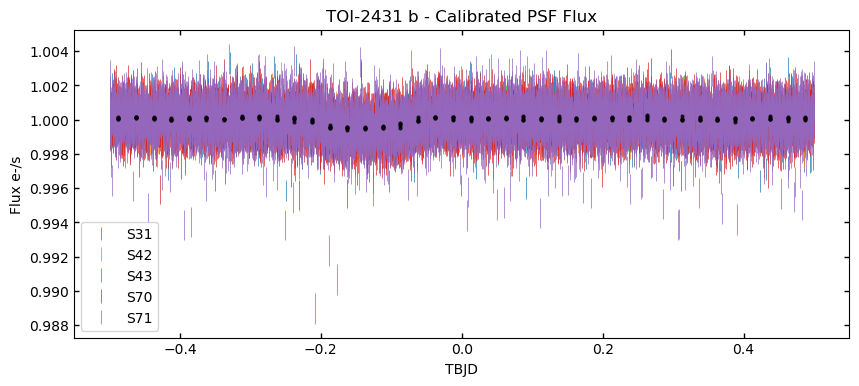

In [8]:
#We can also plot all the sector together as follows.
#We first define the figure that will have all of the sectors.
plt.figure(figsize = (10,4))

#We then define the period of our planet.
#period = 0.2241957793229586
period = 0.224195

#We define lists to contain the Times, Flux, and flux errors of the TGLC light curves for further use.
TGLC_times = []
TGLC_flux = []
TGLC_flux_err = []

#We then go through each fits file and plot the calibrated PSF flux.
for i,fits_file in enumerate(fits_list):
    hdul = fits.open(fits_file)

    #We first filter out bad datapoints from both TESS FFI flags and TGLC flags.
    q = [a and b for a,b in zip(list(hdul[1].data['TESS_flags'] == 0),
                                list(hdul[1].data['TGLC_flags'] == 0))]

    #We take the time.
    time = hdul[1].data["time"][q]

    #Depending on the sector we have to bin the sectors.
    if i <= 26:
        #Primary mission is 1800 seconds.
        time = time

    elif (i > 27 and i <= 55):
        #Since first extended mission is 600 seconds, we bin 3 points => 600 x 3 = 1800 seconds
        time = np.mean(time[:len(time) // 3 * 3].reshape(-1, 3), axis=1)

    elif (i >= 56):
        #Since second extended mission is 200 seconds, we bin 9 points => 200 x 9 = 1800 seconds
        time = np.mean(time[:len(time) // 9 * 9].reshape(-1, 9), axis=1)

    #We then define the phase:
    phase = (time % period) / period
    phase[phase > 0.5] -= 1
    
    #We take the raw Aperature flux and its errors.
    aper_flux = hdul[1].data['cal_aper_flux'][q]
    aper_flux_err = hdul[1].header['CAPE_ERR']

    #We plot the light curve.
    plt.errorbar(phase, aper_flux, aper_flux_err, marker = '', lw=0.5, ls = '', label = f'S{sector_list[i]}')

    #We plot the binned midpoints.
    phase_bin, flux_bin = bin_lc(phase, aper_flux)
    plt.plot(phase_bin, flux_bin, ".", color="black", markersize=4, alpha=0.7, zorder=10)

    #We add the times and fluxes to the TGLC_light_curve list.
    for j, bjd in enumerate(time):
        TGLC_times.append(time[j])
        TGLC_flux.append(aper_flux[j])
        TGLC_flux_err.append(aper_flux_err)

plt.title("TOI-2431 b - Calibrated PSF Flux")
plt.xlabel("TBJD")
plt.ylabel("Flux e-/s")
plt.legend()
plt.show()

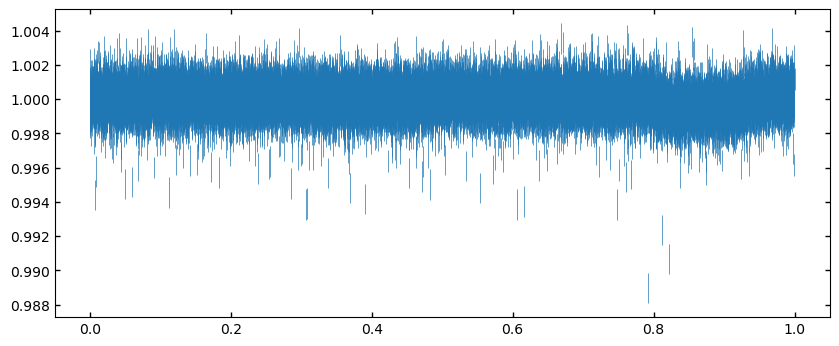

In [9]:
#We convert our TGLC_times, TGLC_flux, and TGLC_flux_err to numpy arrays.
TGLC_times = np.array(TGLC_times)
TGLC_flux = np.array(TGLC_flux)
TGLC_flux_err = np.array(TGLC_flux_err)

#We can now plot the TGLC light curve.
plt.figure(figsize=(10, 4))
plt.errorbar((TGLC_times % period)/period, TGLC_flux, TGLC_flux_err, marker = '', lw=0.5, ls = '')
plt.show()

In [11]:
#We combine the arrays into a single 2D array
data = np.column_stack((TGLC_times, TGLC_flux, TGLC_flux_err))
print(data)

[[2.14452317e+03 1.00244987e+00 6.33567205e-04]
 [2.14453012e+03 1.00190878e+00 6.33567205e-04]
 [2.14453706e+03 1.00198662e+00 6.33567205e-04]
 ...
 [3.25936287e+03 1.00175822e+00 8.88518095e-04]
 [3.25936518e+03 9.97316182e-01 8.88518095e-04]
 [3.25936750e+03 1.00017786e+00 8.88518095e-04]]


In [12]:
#We then save the data into a .txt file in CSV format for the juliet joint fit.
np.savetxt("TGLC_light_curve.csv", data, delimiter=",", header="times,flux,flux_err", comments="")